In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os

In [2]:
# selective search
def non_max_suppression(boxes, overlap_thresh=0.3):
    if len(boxes) == 0:
        return []

    # Convert boxes to numpy array
    boxes = np.array(boxes)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]

    # Compute area of the boxes
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = np.argsort(areas)  # Sort by area

    keep = []
    while len(order) > 0:
        i = order[-1]  # Index of the largest box
        keep.append(i)

        # Compute intersection-over-union (IoU)
        xx1 = np.maximum(x1[i], x1[order[:-1]])
        yy1 = np.maximum(y1[i], y1[order[:-1]])
        xx2 = np.minimum(x2[i], x2[order[:-1]])
        yy2 = np.minimum(y2[i], y2[order[:-1]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        inter = w * h

        iou = inter / (areas[i] + areas[order[:-1]] - inter)
        order = order[
            np.where(iou <= overlap_thresh)
        ]  # Keep boxes with IoU <= threshold

    return boxes[keep].tolist()


# Load the image
image = cv2.imread("/app/packtisch/frames/2024-09-23_14-17-19_cam2/1120.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Initialize Selective Search
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)

# Use "fast" or "quality" mode
ss.switchToSelectiveSearchFast()  # Faster, fewer proposals
# ss.switchToSelectiveSearchQuality()  # Slower, more proposals

# Generate proposals
rects = ss.process()
print(f"Total proposals: {len(rects)}")

# Apply NMS to reduce proposals
nms_rects = non_max_suppression(rects, overlap_thresh=0.2)
print(f"Proposals after NMS: {len(nms_rects)}")

# Rank proposals by total edge strength
edges = cv2.Canny(image, 100, 200)
ranked_rects = sorted(rects, key=lambda rect: np.sum(edges[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]), reverse=True)

# Visualize the first few proposals
for i, rect in enumerate(ranked_rects[:30]):  # Limit to first 100 proposals
    x, y, w, h = rect
    cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Display the image
plt.imshow(image_rgb)
plt.axis("off")
plt.show()

NameError: name 'cv2' is not defined

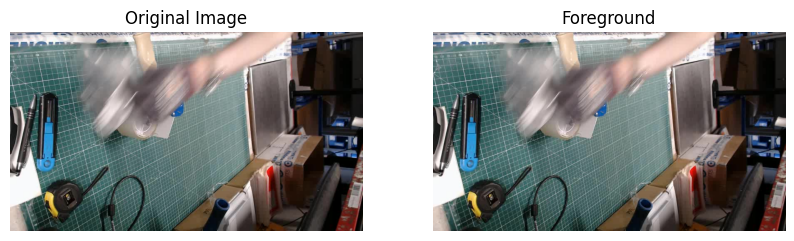

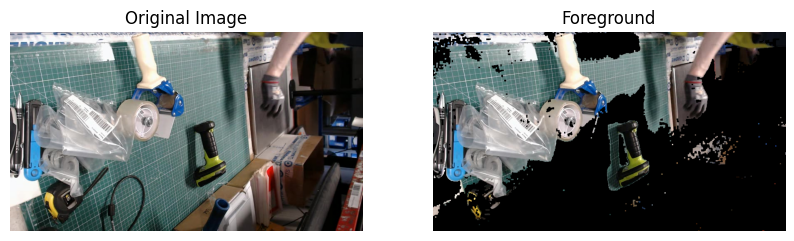

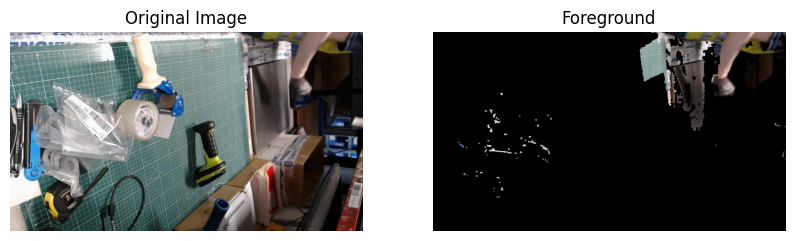

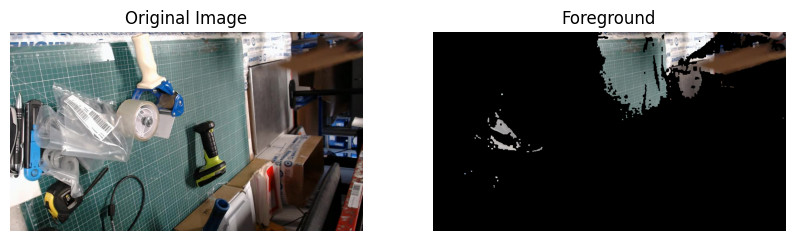

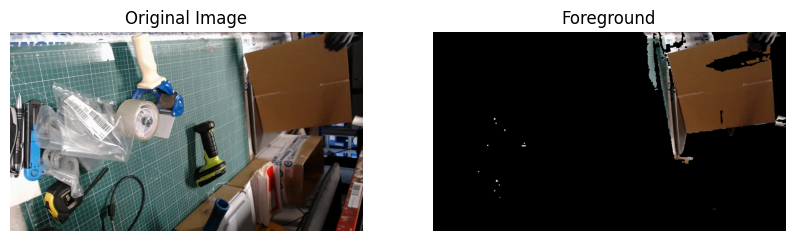

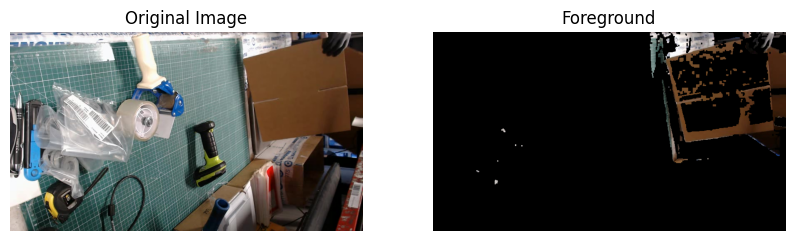

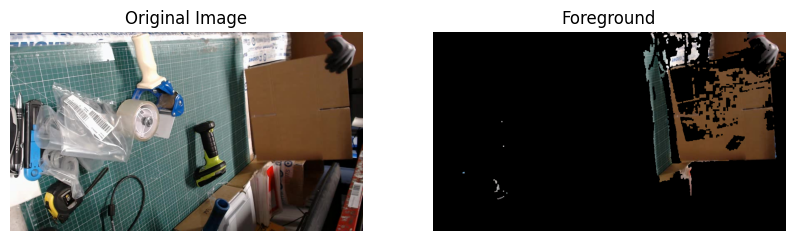

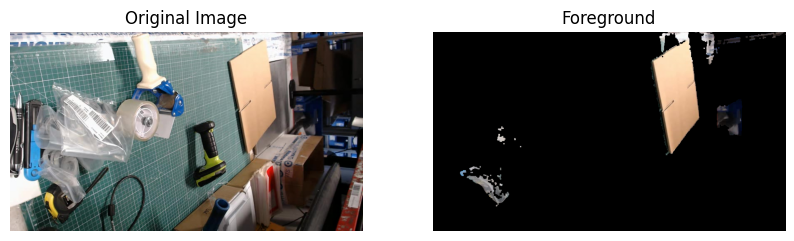

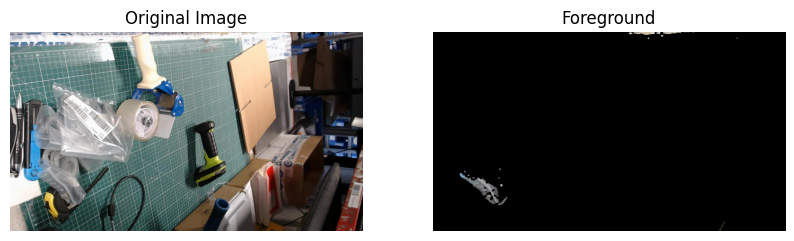

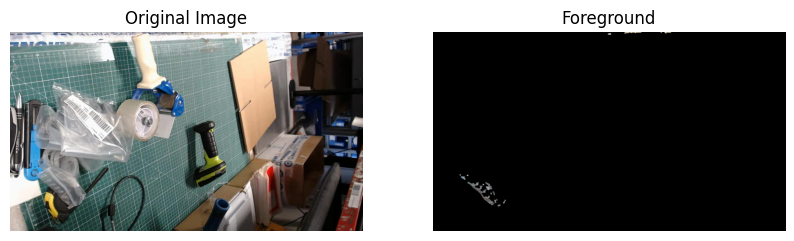

In [9]:
# Mixture of Gaussian for background segmentation
# Open video capture
image_folder  = '/app/packtisch/reduced_frames/2024-09-23_14-17-19_cam2'

# Create background subtractor (MOG2)
fgbg = cv2.createBackgroundSubtractorMOG2()

# Loop over the images in the folder
for filename in sorted(os.listdir(image_folder))[::20]: # only use some images
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Add other formats if needed
        image_path = os.path.join(image_folder, filename)
        image = cv2.imread(image_path)

        # # Apply background subtraction
        fgmask = fgbg.apply(image)

        # # Perform some cleaning (optional)
        fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, None)  # Remove noise
        fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, None)  # Close small holes

        # # Extract the foreground (the moving object(s))
        foreground = cv2.bitwise_and(image, image, mask=fgmask)

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        foreground_rgb = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)

        # Display the result using Matplotlib
        plt.figure(figsize=(10, 5))

        # Show original image
        plt.subplot(1, 2, 1)
        plt.imshow(image_rgb)
        plt.title("Original Image")
        plt.axis('off')  # Hide axes

        # Show foreground
        plt.subplot(1, 2, 2)
        plt.imshow(foreground_rgb)
        plt.title("Foreground")
        plt.axis('off')  # Hide axes

        plt.show()  # Render the images in the notebook

        cv2.waitKey(100)  # Add a slight delay if you want to see the images one by one

cv2.destroyAllWindows()